## Projeto Final Aprendizado de Máquina

#### Duplas: Aliança BA-AL e Nemphis & Nempharey

#### Integrantes: Davi J.A. Pereira, Diogo P. de L. Carvalho, Mayllon E.P.S. Silva, Samuel S. de Araújo

### Notebook 4: RANSAC, Regressão linear e kNN

Para iniciarmos o estudo precisaremos de bibliotecas específicas disponibilizadas pelo python. Esse tipo de ferramente será muito útil no decorrer do notebook para cálculos de comparações, gráficos etc..

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import RANSACRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error 
from sklearn.metrics import r2_score as r2
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression



In [2]:
superconductors_dataset = pd.DataFrame(pd.read_csv("Dataset_superconductors_2.csv"))

In [3]:
superconductors_dataset

,mean_atomic_mass,wtd_range_atomic_mass,std_atomic_mass,gmean_fie,wtd_range_fie,mean_atomic_radius,wtd_range_atomic_radius,std_atomic_radius,wtd_entropy_Density,range_Density,...,mean_ThermalConductivity,wtd_gmean_ThermalConductivity,entropy_ThermalConductivity,wtd_entropy_ThermalConductivity,wtd_range_ThermalConductivity,gmean_Valence,range_Valence,wtd_range_Valence,wtd_std_Valence,critical_temp
0,88.944468,31.794921,51.968828,718.152900,735.985714,160.250000,42.914286,75.237540,0.814598,8958.571,...,107.756645,0.621979,0.308148,0.262848,57.127669,2.213364,1,1.085714,0.437059,29.00
1,92.729214,36.161939,47.094633,720.605511,743.164286,161.200000,50.571429,67.321319,0.914802,10488.571,...,172.205316,0.619735,0.847404,0.567706,51.413383,1.888175,2,1.128571,0.468606,26.00
2,88.944468,35.741099,51.968828,718.152900,743.164286,160.250000,49.314286,75.237540,0.760305,8958.571,...,107.756645,0.619095,0.308148,0.250477,57.127669,2.213364,1,1.114286,0.444697,19.00
3,88.944468,33.768010,51.968828,718.152900,739.575000,160.250000,46.114286,75.237540,0.788889,8958.571,...,107.756645,0.620535,0.308148,0.257045,57.127669,2.213364,1,1.100000,0.440952,22.00
4,88.944468,27.848743,51.968828,718.152900,728.807143,160.250000,36.514286,75.237540,0.859811,8958.571,...,107.756645,0.624878,0.308148,0.272820,57.127669,2.213364,1,1.057143,0.428809,23.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21258,106.957877,15.504479,65.764081,651.611213,427.546667,176.500000,57.808889,45.883003,1.110551,7511.000,...,65.500000,95.001493,1.029002,0.634332,83.048889,3.223710,1,2.168889,0.496904,2.44
21259,92.266740,7.353333,69.232655,702.115184,659.771429,159.200000,20.285714,67.211309,1.080432,11848.571,...,132.805316,1.577047,0.949904,0.745515,76.176553,2.168944,1,0.904762,0.212959,122.10
21260,99.663190,53.041104,6.756810,730.207231,370.180000,183.500000,124.600000,14.500000,0.572700,3453.000,...,62.500000,57.038314,0.683870,0.559446,29.000000,4.472136,1,3.200000,0.400000,1.98
21261,99.663190,31.115202,6.756810,730.207231,208.799000,183.500000,84.230000,14.500000,0.667210,3453.000,...,62.500000,58.781651,0.683870,0.659671,15.250000,4.472136,1,2.210000,0.462493,1.84


In [4]:
FEATURES = list(superconductors_dataset.columns[:-1])
TARGET = ["critical_temp"]

In [5]:
X = superconductors_dataset.reindex(FEATURES, axis=1)
y = superconductors_dataset.reindex(TARGET, axis=1)

Abaixo, iniciamos a divisão do conjunto de dados em treino e teste para ajustalos no futuro aos modelos que utlizaremos

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=61455)

### RANSAC

O modelo linear representado abaixo é o "RANSAC Regressor", antes de iniciarmos a explorar mais sobre esse modelo e suas utilidades, devemos observar o significado por trás do nome dado ao algoritmo "RANSAC" e suas origens. "RANSAC" significa "RANdom SAmple Consensus", e é um método iterativo para estimar parâmetros de um modelo matemático [1]. No contexto do aprendizado de máquina e análise de dados, esse modelo é usando para encontar o melhor ajuste estaístico mesmo com a existência de outliers (valores que fogem do padrão), para isso, o modelo seleciona aleatóriamente valores do conjunto de dados escolhidos, o que dá o significado ao primeiro e segundo termo de sua nomecaltura, respectivamente, ("RANdom" para aleatório), e ("SAmple para amostra). Mas, e quanto ao termo que acrescenta o "C" no nome "RANSAC"? Esse termo é acrescentado devido ao fato de que nas inumeras iterações do modelo, o mesmo faz a busca no conjunto de dados e verifica quantos se ajustam ao modelo traçado, repetindo esse processo diversas vezes chega-se a conclusão com um único modelo escolhido, o que acolheu mais pontos. Esse processo é chamado de "Consensus", e é a etapa final do algoritmo para selecionar o modelo final de regressão [2]. Assim como todo modelo usado em aprendizado de máquina, o "RANSAC" possui importantes parâmetros essenciais para seu funcionamento que iremos explorar no decorrer do notebook, mas antes disso, podemos detalhar mais sobre o processo de escolha de regressão do "RANSAC".

<ol>
    <li><b>Etapa de Amostragem:</b></li> Essa etapa é feita a partir da escolha de valores no conjunto de dados que serão usados para interpolação do modelo de regressão. Assim como diz o nome, essa etapa é tida como aleatória (estritamente falando, pseudoaleatória, pois estamos tratando de sistemas computacionais), isso por que na etapa de escolha, o algoritmo não é influenciado por nenhuma característica ou estado dos dados do conjunto
    <li><b>Interpolação modelo</b></li> Nessa etapa, usando a amostragem feita na etapa anterior, podemos traçar a melhor retea que intercepta os pontos, por padrão, o scikit usa o LinearRegression. 
    <li><b>Inliers e Outliers</b></li>Com o modelo pronto, acontece a verificação dos valores que não foram levados em consideração na interpolação da regressão. Para definir o que pode ser considerado "inlier" ou "outlier" existe um determinado limite, se o valor se enquadra dentro ou fora desse limite, o mesmo será classificado em "inlier" ou "outlier". Após isso, o algoritmo já está pronto para fazer a avaliação de perfomance do modelo
    <li><b>Consenso</b></li>Essa pode ser considerada uma das mais importantes etapas para o modelo, pois é nela que iremos realizar diversas amostragens. Lembre-se que a amostragem aleatória nunca está livre de por exemplo: escolher outliers como base para o modelo. Para isso, as etapas descritas acima não são realizadas uma única vez, mas sim diversas, com isso, teremos uma ampla gama de resultados do modelo e podemos escolher o que mais se adequa a regressão, em outras palavras, o modelo que mais considera "inliers" e desconsidera "outliers".
</ol>

Abaixo, iniciamos o processo da criação das instâncias dos modelos necessárias para o estudo do caso. Sabendo que o RANSAC tem como base os modelos de LinearRegression, também utilizaremos a regressão linear como parâmetro. Além disso, usaremos o pipeline para criar modelos compostos do "RANSAC" para comparações no futuro. Utilizaremos as mesmas ferramentas passadas em sala de aula, como por exemplo: normalização padrão usando o "StandardScaler" ou transformação linear com o "PCA". Sabendo que o RANSAC se trata de um modelo de regressão com base no "LinearRegression", em muitos momentos do notebook compararemos o uso desse algoritmo com o RANSAC.

### Otimização de hiperparâmetros do RANSAC

Para o processo de otimização de hiperparâmetros deveremos inicializar um função que normalmente é chamada de função objetivo, em que nela novamente faremos o processo de divisão de treino e teste e com base no optuna nos retornará ao final do processo os melhores parâmetros para o modelo RANSAC. A otimização de hiperparâmetros é uma importante etapa pois nos informa quais os valores que trará uma significativa melhora para nosso modelo

In [7]:
# os códigos abaixo (otimização) foram retirados do notebook "11 - Otimização de hiperparâmetros" disponibilizado pelo professor
from optuna import create_study, Trial
TAMANHO_TESTE = 0.1
SEMENTE_ALEATORIA = 61455
NUM_FOLDS = 10
NUM_TENTATIVAS = 100

In [8]:
def cria_instancia_modelo(trial):
    """Cria uma instância do modelo.

    Args:
      trial: objeto tipo Trial do optuna.

    Returns:
      Uma instância do modelo desejado.
    """

    parametros = {
        "min_samples":trial.suggest_int('min_samples', 1, 10),
        "max_trials" : trial.suggest_int('max_trials', 50, 200),
        "stop_score" : trial.suggest_float('stop_score', 0.01, 10.0),
        }

    model = RANSACRegressor(**parametros)

    return model

In [9]:
def funcao_objetivo(
    trial,
    X,
    y,
    num_folds=NUM_FOLDS,
):
    """Função objetivo do optuna

    Referencia:
      https://medium.com/@walter_sperat/ using-optuna-with-sklearn-the-right-way-part-1-6b4ad0ab2451
    """

    modelo = cria_instancia_modelo(trial)

    metricas = cross_val_score(
        modelo,
        X,
        y,
        scoring="neg_root_mean_squared_error",
        cv=NUM_FOLDS,
    )

    # releia sobre scores no sklearn para relembrar porque tem um negativo abaixo
    return -metricas.mean()

In [10]:
objeto_de_estudo = create_study(direction="minimize")

[I 2023-11-15 20:04:58,451] A new study created in memory with name: no-name-0fed4efe-b090-425c-bf2e-153c503ca62b


In [11]:
def funcao_objetivo_parcial(trial):
    return funcao_objetivo(trial, X_train, y_train)

In [12]:
objeto_de_estudo.optimize(funcao_objetivo_parcial, n_trials=NUM_TENTATIVAS)

[I 2023-11-15 20:05:00,725] Trial 0 finished with value: 36.50453600106883 and parameters: {'min_samples': 3, 'max_trials': 137, 'stop_score': 9.945570428393307}. Best is trial 0 with value: 36.50453600106883.
[I 2023-11-15 20:05:05,505] Trial 1 finished with value: 35.22465943523095 and parameters: {'min_samples': 5, 'max_trials': 122, 'stop_score': 2.6531489930161025}. Best is trial 1 with value: 35.22465943523095.
[I 2023-11-15 20:05:10,134] Trial 2 finished with value: 29.41456243410219 and parameters: {'min_samples': 10, 'max_trials': 72, 'stop_score': 2.283454217498007}. Best is trial 2 with value: 29.41456243410219.
[I 2023-11-15 20:05:13,825] Trial 3 finished with value: 29.167223355434544 and parameters: {'min_samples': 9, 'max_trials': 56, 'stop_score': 3.4257115577015553}. Best is trial 3 with value: 29.167223355434544.
[I 2023-11-15 20:05:16,812] Trial 4 finished with value: 36.673666604892006 and parameters: {'min_samples': 4, 'max_trials': 81, 'stop_score': 5.740313204840

In [13]:
df = objeto_de_estudo.trials_dataframe()

df

,number,value,datetime_start,datetime_complete,duration,params_max_trials,params_min_samples,params_stop_score,state
0,0,36.504536,2023-11-15 20:04:58.620114,2023-11-15 20:05:00.725357,0 days 00:00:02.105243,137,3,9.945570,COMPLETE
1,1,35.224659,2023-11-15 20:05:00.735436,2023-11-15 20:05:05.505746,0 days 00:00:04.770310,122,5,2.653149,COMPLETE
2,2,29.414562,2023-11-15 20:05:05.522111,2023-11-15 20:05:10.134503,0 days 00:00:04.612392,72,10,2.283454,COMPLETE
3,3,29.167223,2023-11-15 20:05:10.142026,2023-11-15 20:05:13.825861,0 days 00:00:03.683835,56,9,3.425712,COMPLETE
4,4,36.673667,2023-11-15 20:05:13.834672,2023-11-15 20:05:16.810444,0 days 00:00:02.975772,81,4,5.740313,COMPLETE
...,...,...,...,...,...,...,...,...,...
95,95,29.929479,2023-11-15 20:11:43.887267,2023-11-15 20:11:49.495838,0 days 00:00:05.608571,98,10,1.706237,COMPLETE
96,96,149.264941,2023-11-15 20:11:49.504274,2023-11-15 20:11:50.289608,0 days 00:00:00.785334,68,4,0.771732,COMPLETE
97,97,34.318582,2023-11-15 20:11:50.300631,2023-11-15 20:11:56.950496,0 days 00:00:06.649865,124,7,2.966712,COMPLETE
98,98,31.337397,2023-11-15 20:11:56.959147,2023-11-15 20:12:02.517565,0 days 00:00:05.558418,104,9,3.301678,COMPLETE


In [15]:
melhor_trial = objeto_de_estudo.best_trial

print(f"Número do melhor trial: {melhor_trial.number}")
print(f"Parâmetros do melhor trial: {melhor_trial.params}")

Número do melhor trial: 22
Parâmetros do melhor trial: {'min_samples': 9, 'max_trials': 92, 'stop_score': 1.5619289204742688}


Observação ao leitor: no momento de execução desse código, os hiperparâmetros que tiveram a melhor performance foram os seguintes:

Número do melhor trial: 22
Parâmetros do melhor trial: {'min_samples': 9, 'max_trials': 92, 'stop_score': 1.5619289204742688}

Com os dados retornados pela otimização, podemos aplicalos em nossos modelos

In [17]:

modelo_RANSAC_composto_SD = make_pipeline(
     StandardScaler(),
     RANSACRegressor(min_samples=9, max_trials=92, stop_score = 1.5619289204742688)
)

modelo_RANSAC_composto_PCA = make_pipeline(
    PCA(8),
    RANSACRegressor(min_samples=9, max_trials=92, stop_score = 1.5619289204742688)
)

modelo_RANSAC_comum = RANSACRegressor(min_samples=9, max_trials=92, stop_score = 1.5619289204742688)

modelo_regressao_linear = LinearRegression()

modelo_RG_composto_SD = make_pipeline(
    StandardScaler(),
    LinearRegression()
)

modelo_RG_composto_PCA = make_pipeline(
    PCA(8),
    LinearRegression()
)

### Testes com atributos

Abaixo, inicio o teste do modelo "RANSAC"com dois atributos do nosso dataset. A partir da análise de correlação que fizemos no inicio, escolhi duas variávies que possuem correlações que nos retornariam um plot linear podendo ele ser tanto positivo, quanto negativo (nesse caso, negativo), algo que poderá ser melhor visto quando plotarmos esses dados em um gráfico. Os atributos escolhidos foram respectivamente "entropyFusionHeat" e "wtd_entropyFusionHeat", para isso, ajustamos os dados aos modelos criados anteriormente e efetuamos a predição dos valores.

<AxesSubplot: xlabel='gmean_fie', ylabel='mean_atomic_radius'>

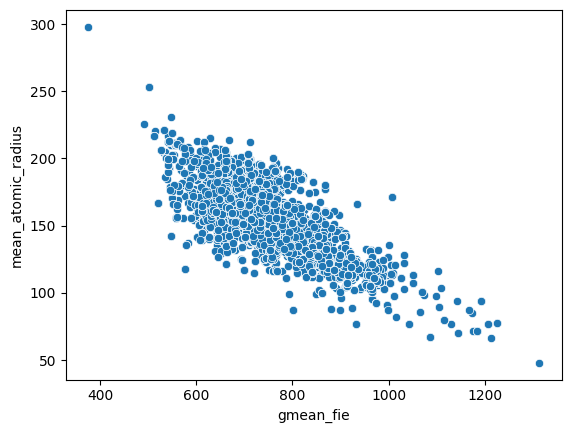

In [18]:
sns.scatterplot(x=superconductors_dataset["gmean_fie"], y=superconductors_dataset["mean_atomic_radius"])

Execeutamos o já conhecido processo de "fit", que ajusta o modelo utilizado aos dados que passamos como parâmetros e logo em seguida fazemos a predição de novos valores para o "Target" utilizando o processo de "predict". Faremos esse processo para os dois tipos de modelo: "RANSAC" e para comparações com o mesmo, "LinearRegression"

In [19]:
teste_entropyFusionHeat, teste_wtd_entropyFusionHeat = superconductors_dataset["gmean_fie"].values,superconductors_dataset["mean_atomic_radius"].values 
teste_entropyFusionHeat = teste_entropyFusionHeat.reshape(-1,1)
teste_wtd_entropyFusionHeat = teste_wtd_entropyFusionHeat.reshape(-1,1)

modelo_RANSAC_comum.fit(teste_entropyFusionHeat, teste_wtd_entropyFusionHeat)
modelo_regressao_linear.fit(teste_entropyFusionHeat, teste_wtd_entropyFusionHeat)
valor_predito_RANSAC = modelo_RANSAC_comum.predict(teste_entropyFusionHeat)
valor_predito_RG = modelo_regressao_linear.predict(teste_entropyFusionHeat)

A parir disso, podemos calcular algumas métricas para analisarmos o resultado final 

In [20]:
RMSE_entropy_RANSAC = mean_squared_error(teste_entropyFusionHeat, valor_predito_RANSAC)
RMSE_entropy_RG = mean_squared_error(teste_entropyFusionHeat, valor_predito_RG)

MAE_entropy_RANSAC = mae(teste_entropyFusionHeat, valor_predito_RANSAC)
MAE_entropy_RG = mae(teste_entropyFusionHeat, valor_predito_RG)

R2_entropy_RANSAC = r2(teste_entropyFusionHeat, valor_predito_RANSAC)
R2_entropy_RG = r2(teste_entropyFusionHeat, valor_predito_RG)

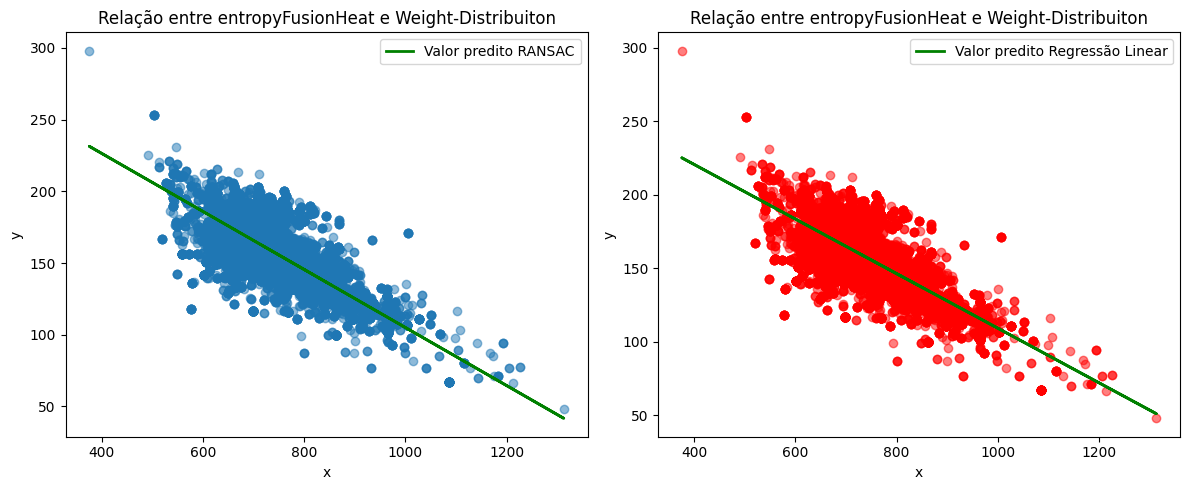

In [21]:
import numpy as np
from sklearn.linear_model import RANSACRegressor

ransac = RANSACRegressor()

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

axes[0].scatter(teste_entropyFusionHeat, teste_wtd_entropyFusionHeat, alpha=0.5,)
axes[0].plot(teste_entropyFusionHeat, valor_predito_RANSAC, color='green', linewidth=2, label='Valor predito RANSAC')
axes[0].set_title('Relação entre entropyFusionHeat e Weight-Distribuiton')
axes[0].set_xlabel('x')
axes[0].set_ylabel('y')
axes[0].legend()

axes[1].scatter(teste_entropyFusionHeat, teste_wtd_entropyFusionHeat, alpha=0.5, color="red")
axes[1].plot(teste_entropyFusionHeat, valor_predito_RG, color='green', linewidth=2, label='Valor predito Regressão Linear')
axes[1].set_title('Relação entre entropyFusionHeat e Weight-Distribuiton')
axes[1].set_xlabel('x')
axes[1].set_ylabel('y')
axes[1].legend()

plt.tight_layout()

plt.show()


Visivelmente, não percebemos diferença alguma entre os gráficos. Isso ocorre porque de fato temos "outliers" no atributo, porém, os mesmo não estão estritamente separados do corpo principal dos dados. Nesse caso, a regressão linear e o RANSAC se tornam extremamente parecidos, porém, se observarmos as métricas conseguimos observar uma modesta vantagem do modelo "RANSAC" com relação à Regressão Linear

In [22]:
print(f"o RMSE do modelo RANSAC para a comparação dos atributos escolhidos foi de {RMSE_entropy_RANSAC}, enquanto o da Regressão Linear {RMSE_entropy_RG}, tendo o modelo RANSAC uma vantagem de {RMSE_entropy_RG - RMSE_entropy_RANSAC}")

o RMSE do modelo RANSAC para a comparação dos atributos escolhidos foi de 344491.7463664683, enquanto o da Regressão Linear 344433.5066945782, tendo o modelo RANSAC uma vantagem de -58.2396718901


In [23]:
print(f"o MAE do modelo RANSAC para a comparação dos atributos escolhidos foi de {MAE_entropy_RANSAC}, enquanto o da Regressão Linear {MAE_entropy_RG}, tendo o modelo RANSAC uma vantagem de {MAE_entropy_RG - MAE_entropy_RANSAC}")

o MAE do modelo RANSAC para a comparação dos atributos escolhidos foi de 579.331370420912, enquanto o da Regressão Linear 579.491650038751, tendo o modelo RANSAC uma vantagem de 0.16027961783902356


In [24]:
print(f"o R2 do modelo RANSAC para a comparação dos atributos escolhidos foi de {R2_entropy_RANSAC}, enquanto o da Regressão Linear {R2_entropy_RG}, tendo o modelo RANSAC uma vantagem de {R2_entropy_RANSAC - R2_entropy_RG}")

o R2 do modelo RANSAC para a comparação dos atributos escolhidos foi de -55.153031344736036, enquanto o da Regressão Linear -55.1435381300055, tendo o modelo RANSAC uma vantagem de -0.009493214730532884


#### Exemplo de eficiência do RANSAC

In [25]:
dataset_exemplo_RANSAC = pd.read_csv("Dataset_exemplo_robusto.csv", delimiter=";", decimal=",")

In [26]:
x2,y2 = dataset_exemplo_RANSAC['X'].values, dataset_exemplo_RANSAC['y'].values
x2 = x2.reshape(-1,1)
y2 = y2.reshape(-1,1)

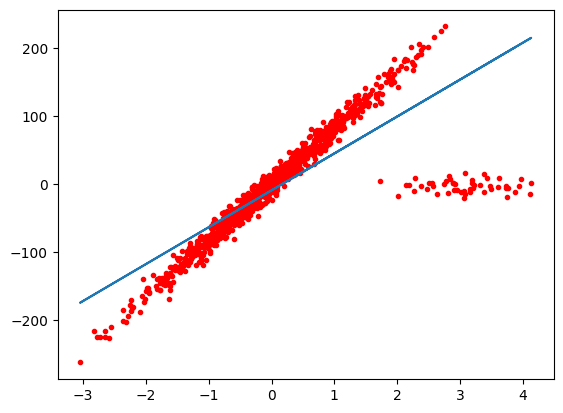

In [27]:
modelo2 = LinearRegression()
modelo2.fit(x2,y2)
plt.scatter(x2,y2, color = 'red', marker = '.')
plt.plot(x2,modelo2.predict(x2))

In [28]:
mae_linear_example = mae(y2, modelo2.predict(x2))

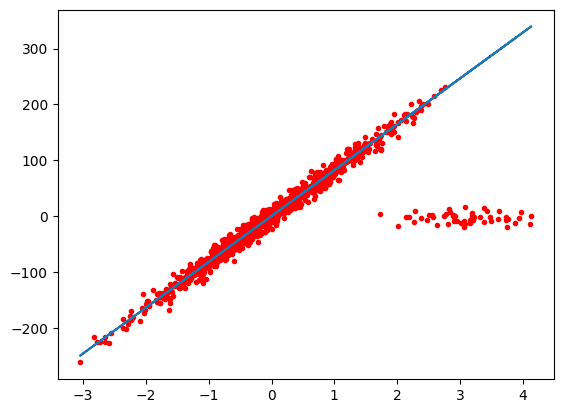

In [29]:
ransac2 = RANSACRegressor()
ransac2.fit(x2,y2)
plt.scatter(x2,y2, color = 'red', marker = '.')
plt.plot(x2,ransac2.predict(x2))

In [30]:
mae_ransac_example = mae(y2, ransac2.predict(x2))

In [31]:
print(f"A métrica MAE para o modelo exemplo utilizando o RANSAC foi {mae_ransac_example} enquanto que utilizando o LinearRegression foi {mae_linear_example}, tendo o RANSAC uma vantagem de {mae_linear_example - mae_ransac_example}")

A métrica MAE para o modelo exemplo utilizando o RANSAC foi 20.341030662543325 enquanto que utilizando o LinearRegression foi 31.146057650637594, tendo o RANSAC uma vantagem de 10.80502698809427


Como pode ser visto acima (utilizando um dataset didático). O modelo de Regressão Linear busca traçar uma reta com equilíbrio entre os dados, enquanto o modelo RANSAC ignora os outliers. Visivelmente falando, o conjunto de dados descrito acima é o que podemos considerar o "paraiso" do modelo RANSAC, pois, os dados considerados "outliers" estão visivelmente distantes do considerado "inliers", o que facilita a visualização de como o RANSAC atua. algo que em nosso cotidiano não é muito comum, porém, o algoritmo continua sendo válido.

### Testes com previsão do conjunto de dados

Acabamos de realizar o uso do modelo RANSAC em uma situação com apenas dois atributos, em nosso caso, duas colunas apenas de um conjunto de dados. Se partirmos agora para o conjunto de dados como um todo, podemos analisar a eficiência do modelo comum (sem nenhum tipo de normalização ou transformação), com os modelos pipeline que criamos no início. Porém, antes disso, podemos realizar os testes com o modelo "LinearRegression" como fonte de comparação".

#### Modelo Regressão Linear com e sem normalização padrão com StandardScaler

Abaixo, inicializaremos novas instâncias dos modelos criados no incio do notebook utilizando pipeline (Modelos com normalização padrão e sem normalização padrão), essas instâncias servirão para a predição de novos valores e comparações futuras

In [32]:
modelo_regressao_linear.fit(X_train,y_train)

y_predito_RG_comum = modelo_regressao_linear.predict(X_test)


In [33]:
modelo_RG_composto_SD.fit(X_train,y_train)

y_predito_RG_composto_SD = modelo_RG_composto_SD.predict(X_test)


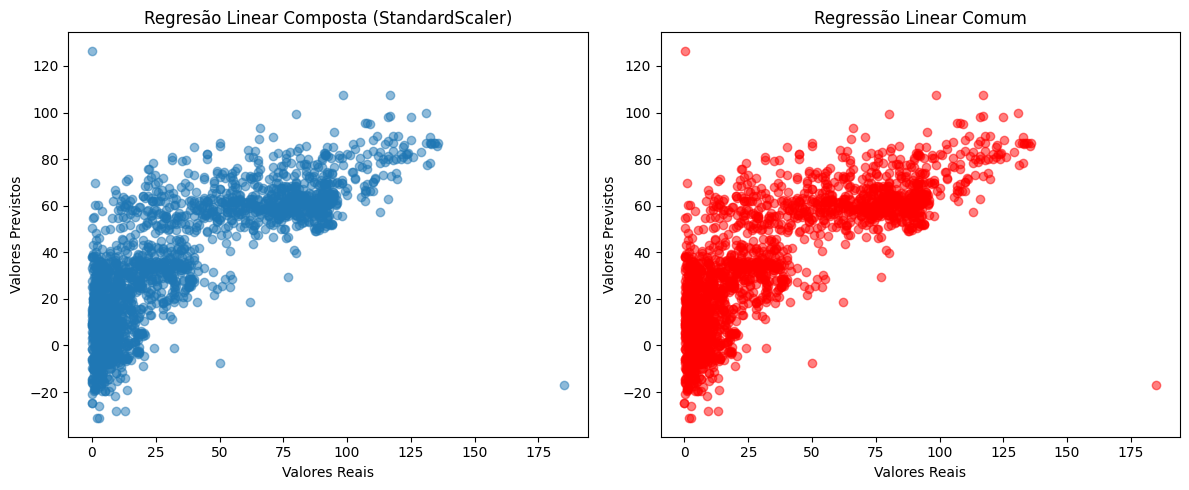

In [34]:

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

axes[0].scatter(y_test, y_predito_RG_composto_SD, alpha=0.5,)
axes[0].set_title('Regresão Linear Composta (StandardScaler)')
axes[0].set_xlabel('Valores Reais')
axes[0].set_ylabel('Valores Previstos')

axes[1].scatter(y_test, y_predito_RG_comum, alpha=0.5, color="red")
axes[1].set_title('Regressão Linear Comum')
axes[1].set_xlabel('Valores Reais')
axes[1].set_ylabel('Valores Previstos')

plt.tight_layout()

plt.show()


In [35]:
RMSE_comum_RG = mean_squared_error(y_test, y_predito_RG_comum, squared=False)
MAE_comum_RG = mae(y_test, y_predito_RG_comum)
R2_comum_RG = r2(y_test, y_predito_RG_comum)
RMSE_composto_RG_SD = mean_squared_error(y_test, y_predito_RG_composto_SD, squared=False)
MAE_composto_RG_SD = mae(y_test, y_predito_RG_comum)
R2_composto_RG_SD = r2(y_test, y_predito_RG_composto_SD)


#### Modelo RANSAC com e sem normalização padrão com StandardScaler

In [36]:
modelo_RANSAC_comum.fit(X_train,y_train)

y_predito_RANSAC_comum = modelo_RANSAC_comum.predict(X_test)


In [37]:
modelo_RANSAC_composto_SD.fit(X_train,y_train)

y_predito_RANSAC_composto_SD = modelo_RANSAC_composto_SD.predict(X_test)


Com os dados de y prvistos obtidos a partir do modelo RANSAC composto e comparando-o com os resultados originais, podemos calcular a reta que passa por esses valores 

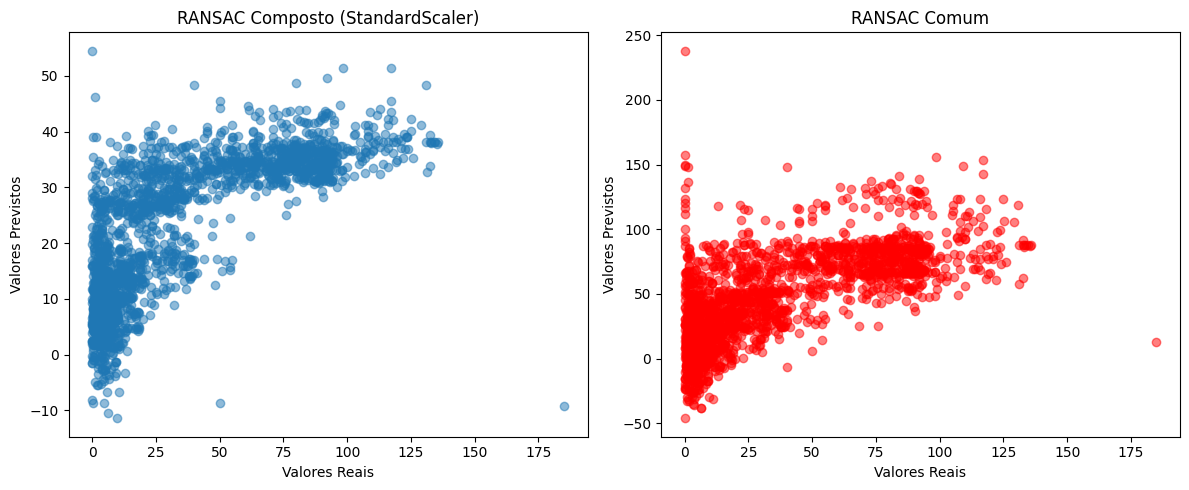

In [38]:

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

axes[0].scatter(y_test, y_predito_RANSAC_composto_SD, alpha=0.5,)
axes[0].set_title('RANSAC Composto (StandardScaler)')
axes[0].set_xlabel('Valores Reais')
axes[0].set_ylabel('Valores Previstos')

axes[1].scatter(y_test, y_predito_RANSAC_comum, alpha=0.5, color="red")
axes[1].set_title('RANSAC Comum')
axes[1].set_xlabel('Valores Reais')
axes[1].set_ylabel('Valores Previstos')

plt.tight_layout()

plt.show()


Com os dados da previsão do RANSAC normalizado e não normalizado em mãos, podemos calcular as métricas de comparação entre os modelos. Esses valores também serão importantes para um verdito final sobre a eficiência do algoritmo em nosso conjunto de dados.

In [39]:
RMSE_comum_RANSAC = mean_squared_error(y_test, y_predito_RANSAC_comum, squared=False)
MAE_comum_RANSAC = mae(y_test, y_predito_RANSAC_comum)
R2_comum_RANSAC = r2(y_test, y_predito_RANSAC_comum)
RMSE_composto_RANSAC_SD = mean_squared_error(y_test, y_predito_RANSAC_composto_SD, squared=False)
MAE_composto_RANSAC_SD = mae(y_test, y_predito_RANSAC_comum)
R2_composto_RANSAC_SD = r2(y_test, y_predito_RANSAC_composto_SD)


Sabendo dos resultados das métricas tanto do RANSAC quanto do modelo de Regressão linear para o nosso conjunto de dados, podemos fazer uma comparação entre o RMSE, MAE e R2, respectivamente, dos dois modelos e obtermos a conclusão se o modelo escolhido (RANSAC) tem alguma vantagem com relação à regressão linear, sendo os dois modelos normalizados ou não normalida

In [40]:
print(f"o RMSE do modelo RANSAC para o conjunto de dados foi de {RMSE_comum_RANSAC}, enquanto o da Regressão Linear {RMSE_comum_RG}, tendo o modelo RANSAC uma desvantagem de {RMSE_comum_RANSAC - RMSE_comum_RG}")

o RMSE do modelo RANSAC para o conjunto de dados foi de 29.22626921911899, enquanto o da Regressão Linear 20.722056979681778, tendo o modelo RANSAC uma desvantagem de 8.504212239437212


In [41]:
print(f"o MAE do modelo RANSAC para o conjunto de dados foi de {MAE_comum_RANSAC}, enquanto o da Regressão Linear {MAE_comum_RG}, tendo o modelo RANSAC uma desvantagem de {MAE_comum_RANSAC - MAE_comum_RG}")

o MAE do modelo RANSAC para o conjunto de dados foi de 21.232613553428592, enquanto o da Regressão Linear 16.194094702163817, tendo o modelo RANSAC uma desvantagem de 5.038518851264776


In [42]:
print(f"o R2 do modelo RANSAC para o conjunto de dados foi de {R2_comum_RANSAC}, enquanto o da Regressão Linear {R2_comum_RG}, tendo o modelo RANSAC uma desvantagem de {R2_comum_RG - R2_comum_RANSAC}")

o R2 do modelo RANSAC para o conjunto de dados foi de 0.29908255614549295, enquanto o da Regressão Linear 0.6476406220709181, tendo o modelo RANSAC uma desvantagem de 0.34855806592542515


#### Modelo RANSAC com e sem PCA

Além dos modelos com normalização padrão estabelecidos no início do notebook, também faremos testes utilizando modelos com redução de dimensionalidade usando de PCA

In [43]:
modelo_RANSAC_composto_PCA.fit(X_train,y_train)

y_predito_RANSAC_composto_PCA = modelo_RANSAC_composto_PCA.predict(X_test)

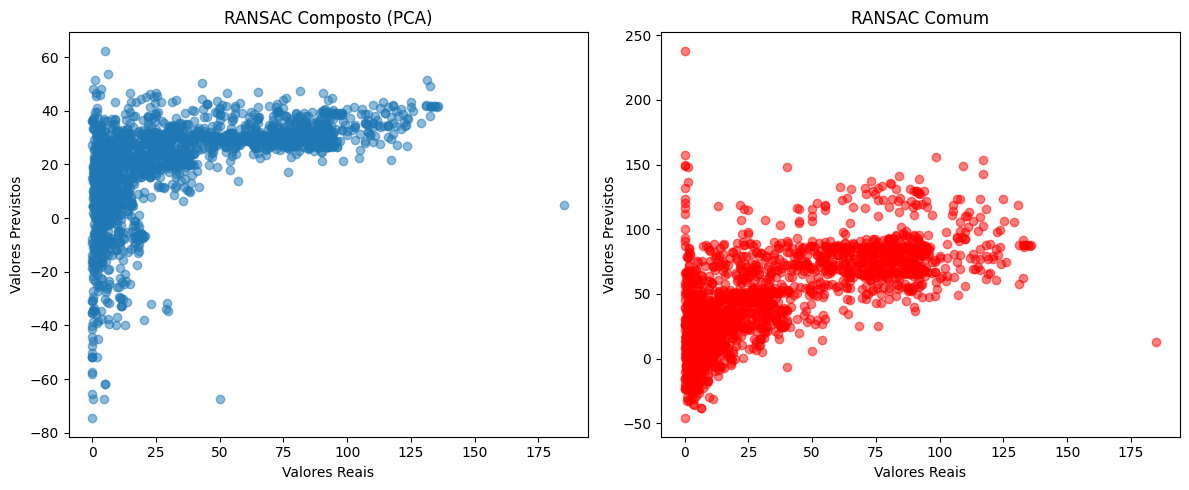

In [44]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

axes[0].scatter(y_test, y_predito_RANSAC_composto_PCA, alpha=0.5, )
axes[0].set_title('RANSAC Composto (PCA)')
axes[0].set_xlabel('Valores Reais')
axes[0].set_ylabel('Valores Previstos')

axes[1].scatter(y_test, y_predito_RANSAC_comum, alpha=0.5, color="red")
axes[1].set_title('RANSAC Comum')
axes[1].set_xlabel('Valores Reais')
axes[1].set_ylabel('Valores Previstos')
plt.tight_layout()

plt.show()


In [45]:
RMSE_composto_RANSAC_PCA = mean_squared_error(y_test, y_predito_RANSAC_composto_PCA, squared=False)
MAE_composto_RANSAC_PCA = mae(y_test, y_predito_RANSAC_composto_PCA)
R2_composto_RANSAC_PCA = r2(y_test, y_predito_RANSAC_composto_PCA)

#### Comparações métricas do Modelo RANSAC

In [46]:
print(f"RMSE modelo RANSAC comum: {RMSE_comum_RANSAC}")
print(f"RMSE modelo RANSAC com StandardScaler: {RMSE_composto_RANSAC_SD}")
print(f"RMSE modelo RANSAC com PCA {RMSE_composto_RANSAC_PCA}")

RMSE modelo RANSAC comum: 29.22626921911899
RMSE modelo RANSAC com StandardScaler: 29.598465131445217
RMSE modelo RANSAC com PCA 33.37813162512964


In [47]:
print(f"MAE modelo RANSAC comum: {MAE_comum_RANSAC}")
print(f"MAE modelo RANSAC com StandardScaler: {MAE_composto_RANSAC_SD}")
print(f"MAE modelo RANSAC com PCA {MAE_composto_RANSAC_PCA}")

MAE modelo RANSAC comum: 21.232613553428592
MAE modelo RANSAC com StandardScaler: 21.232613553428592
MAE modelo RANSAC com PCA 25.101156090392745


In [48]:
print(f"R2 modelo RANSAC comum: {R2_comum_RANSAC}")
print(f"R2 modelo RANSAC com StandardScaler: {R2_composto_RANSAC_SD}")
print(f"R2 modelo RANSAC com PCA {R2_composto_RANSAC_PCA}")

R2 modelo RANSAC comum: 0.29908255614549295
R2 modelo RANSAC com StandardScaler: 0.28111654431887967
R2 modelo RANSAC com PCA 0.085793818728091


Já com os resultados das métricas utilizadas durantes os testes, podemos fazer uma comparação quantitativa entre os diferentes modelos de RANSAC e perceberemos que o modelo comum do RANSAC (tendo os devidos parâmetros obtidos a partir da otimização de hiperparâmetros), se saiu relativamente melhor com relação à normalização padrão com StandardScaler e o modelo com PCA. Dentre as métricas utilizadas como padrão para nossos notebooks, a métrica MAE (mean absolute erro) foi a que obteve o melhor resultado, isso pois o mesmo é uma métrica consideravelmente sensível a outliers

### kNN

In [53]:
from sklearn.neighbors import KNeighborsRegressor

Abaixo formulamos também alguns testes com o modelo "K-neighbors-nearest" ou simplesmente "kNN". O modelo de kNN que iremos utlizar em nossos dados é o que mais se adequa ao contexto do nosso conjunto de dados que possui apenas valores numéricos, nesses caso, o regressor do kNN nos pareceu a melhor opção. No contexto de regressão, o k-NN regressor prevê um valor numérico para uma instância com base nos valores das k instâncias mais próximas no espaço de características. A ideia fundamental é que instâncias semelhantes têm rótulos semelhantes. Em vez de votação como na classificação, os valores dos vizinhos mais próximos são médios ou ponderados para fornecer a previsão contínua. Assim como com o modelo RANSAC, também efetuaremos a otimização de hiperparâmetros com o kNN seguindo o mesmo processo.


In [51]:
def cria_instancia_modelo(trial):
    """Cria uma instância do modelo.

    Args:
      trial: objeto tipo Trial do optuna.

    Returns:
      Uma instância do modelo desejado.
    """

    parametros = {
        "n_neighbors" :trial.suggest_int('n_neighbors', 1, 10),
        "weights" :trial.suggest_categorical('weights', ['uniform', 'distance']),
        "algorithm" :trial.suggest_categorical('algorithm', ['auto', 'ball_tree', 'kd_tree', 'brute']),
        "leaf_size" : trial.suggest_int('leaf_size', 10, 50),
        }

    model = KNeighborsRegressor(**parametros)

    return model

In [52]:
def funcao_objetivo(
    trial,
    X,
    y,
    num_folds=NUM_FOLDS,
):
    """Função objetivo do optuna

    Referencia:
      https://medium.com/@walter_sperat/ using-optuna-with-sklearn-the-right-way-part-1-6b4ad0ab2451
    """

    modelo = cria_instancia_modelo(trial)

    metricas = cross_val_score(
        modelo,
        X,
        y,
        scoring="neg_root_mean_squared_error",
        cv=NUM_FOLDS,
    )

    # releia sobre scores no sklearn para relembrar porque tem um negativo abaixo
    return -metricas.mean()

In [54]:
objeto_de_estudo = create_study(direction="minimize")

[I 2023-11-15 20:22:17,066] A new study created in memory with name: no-name-30836e0b-56e4-4fa4-a504-8da3d2bc2a99


In [55]:
def funcao_objetivo_parcial(trial):
    return funcao_objetivo(trial, X_train, y_train)

In [56]:
objeto_de_estudo.optimize(funcao_objetivo_parcial, n_trials=NUM_TENTATIVAS)

[I 2023-11-15 20:22:47,125] Trial 0 finished with value: 13.521717750657 and parameters: {'n_neighbors': 6, 'weights': 'uniform', 'algorithm': 'ball_tree', 'leaf_size': 47}. Best is trial 0 with value: 13.521717750657.
[I 2023-11-15 20:22:49,154] Trial 1 finished with value: 13.94054958028914 and parameters: {'n_neighbors': 8, 'weights': 'uniform', 'algorithm': 'auto', 'leaf_size': 29}. Best is trial 0 with value: 13.521717750657.
[I 2023-11-15 20:22:56,607] Trial 2 finished with value: 13.642524922293958 and parameters: {'n_neighbors': 1, 'weights': 'distance', 'algorithm': 'ball_tree', 'leaf_size': 47}. Best is trial 0 with value: 13.521717750657.
[I 2023-11-15 20:23:01,448] Trial 3 finished with value: 12.418340428248433 and parameters: {'n_neighbors': 5, 'weights': 'distance', 'algorithm': 'kd_tree', 'leaf_size': 48}. Best is trial 3 with value: 12.418340428248433.
[I 2023-11-15 20:23:06,555] Trial 4 finished with value: 12.807660924779677 and parameters: {'n_neighbors': 3, 'weight

In [57]:
df = objeto_de_estudo.trials_dataframe()

df

,number,value,datetime_start,datetime_complete,duration,params_algorithm,params_leaf_size,params_n_neighbors,params_weights,state
0,0,13.521718,2023-11-15 20:22:40.136102,2023-11-15 20:22:47.125236,0 days 00:00:06.989134,ball_tree,47,6,uniform,COMPLETE
1,1,13.940550,2023-11-15 20:22:47.135448,2023-11-15 20:22:49.154660,0 days 00:00:02.019212,auto,29,8,uniform,COMPLETE
2,2,13.642525,2023-11-15 20:22:49.159067,2023-11-15 20:22:56.607200,0 days 00:00:07.448133,ball_tree,47,1,distance,COMPLETE
3,3,12.418340,2023-11-15 20:22:56.622782,2023-11-15 20:23:01.447841,0 days 00:00:04.825059,kd_tree,48,5,distance,COMPLETE
4,4,12.807661,2023-11-15 20:23:01.460087,2023-11-15 20:23:06.555040,0 days 00:00:05.094953,kd_tree,10,3,uniform,COMPLETE
...,...,...,...,...,...,...,...,...,...,...
95,95,12.414655,2023-11-15 20:26:36.655739,2023-11-15 20:26:38.485862,0 days 00:00:01.830123,brute,37,5,distance,COMPLETE
96,96,12.379668,2023-11-15 20:26:38.498942,2023-11-15 20:26:40.813804,0 days 00:00:02.314862,auto,15,3,distance,COMPLETE
97,97,12.360542,2023-11-15 20:26:40.825877,2023-11-15 20:26:42.758923,0 days 00:00:01.933046,brute,30,4,distance,COMPLETE
98,98,12.360542,2023-11-15 20:26:42.772372,2023-11-15 20:26:44.366021,0 days 00:00:01.593649,brute,43,4,distance,COMPLETE


In [58]:
melhor_trial = objeto_de_estudo.best_trial

print(f"Número do melhor trial: {melhor_trial.number}")
print(f"Parâmetros do melhor trial: {melhor_trial.params}")

Número do melhor trial: 27
Parâmetros do melhor trial: {'n_neighbors': 4, 'weights': 'distance', 'algorithm': 'brute', 'leaf_size': 13}


Observação ao leitor: no momento de execução desse código, os hiperparâmetros que tiveram a melhor performance foram os seguintes:

Número do melhor trial: 27
Parâmetros do melhor trial: {'n_neighbors': 4, 'weights': 'distance', 'algorithm': 'brute', 'leaf_size': 13}

Novamente, com os dados retornados pela otimização, podemos aplicalos em nossos modelos, dessa vez, no kNN

In [63]:

modelo_knn_composto = make_pipeline(
    StandardScaler(), 
    KNeighborsRegressor(n_neighbors=4, weights="distance", algorithm= 'brute', leaf_size= 13))

modelo_comum = KNeighborsRegressor(n_neighbors=4, weights="distance", algorithm= 'brute', leaf_size= 13)

In [64]:
modelo_knn_composto.fit(X_train, y_train)


y_previsto_composto_knn = modelo_knn_composto.predict(X_test)

In [65]:
modelo_comum.fit(X_train, y_train)

y_previsto_comum_knn = modelo_comum.predict(X_test)

In [66]:
RMSE_comStdknn = mean_squared_error(y_test, y_previsto_composto_knn, squared=False)
MAE_comStdknn = mae(y_test, y_previsto_composto_knn)
R2_comStdknn = r2(y_test, y_previsto_composto_knn)
RMSE_comum_knn = mean_squared_error(y_test, y_previsto_comum_knn, squared=False)
MAE_comum_knn = mae(y_test, y_previsto_comum_knn)
R2_comum_knn = r2(y_test, y_previsto_composto_knn)

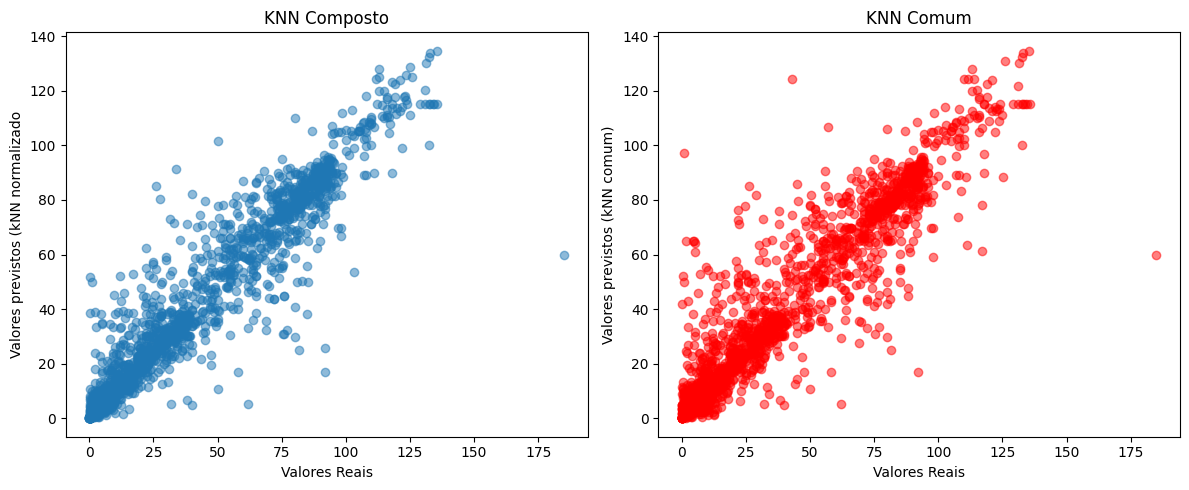

In [67]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

axes[0].scatter(y_test, y_previsto_composto_knn, alpha=0.5,)
axes[0].set_title('KNN Composto')
axes[0].set_xlabel('Valores Reais')
axes[0].set_ylabel('Valores previstos (kNN normalizado')

axes[1].scatter(y_test, y_previsto_comum_knn, alpha=0.5, color="red")
axes[1].set_title('KNN Comum')
axes[1].set_xlabel('Valores Reais')
axes[1].set_ylabel('Valores previstos (kNN comum)')

plt.tight_layout()

plt.show()


No gráfico acima, plotamos os valores reais do nosso target pelos valores previstos pelo algoritmo kNN com normalização e sem normalização. Sabemos que o modelo ideal é aquele que mais se aproxima de uma reta crescente, confirmando que a relação entre os valores reais e previsto segue um padrão. Pode ser observado acima que o algoritmo regressor do kNN se demonstrou muito útil nesse tipo de previsão para nosso conjunto de dados, o que também pode ser observado se utilizarmos as métricas estabelecidas no notebook principal para confirmarmos os resultados. 

In [71]:
print(f"o RMSE do modelo kNN sem normalização foi de {RMSE_comum_knn}, enquanto o com normalização foi {RMSE_comStdknn}, tendo o modelo com normalização uma vantagem de {RMSE_comum_knn - RMSE_comStdknn}")

o RMSE do modelo kNN sem normalização foi de 11.852830242333086, enquanto o com normalização foi 10.007620139990447, tendo o modelo com normalização uma vantagem de 1.845210102342639


In [72]:
print(f"o MAE do modelo kNN sem normalização foi de {MAE_comum_knn}, enquanto o com normalização foi {MAE_comStdknn}, tendo o modelo com normalização uma vantagem de {MAE_comum_knn - MAE_comStdknn}")

o MAE do modelo kNN sem normalização foi de 6.476844924132775, enquanto o com normalização foi 5.293800590926539, tendo o modelo com normalização uma vantagem de 1.1830443332062357


In [73]:
print(f"o R2 do modelo kNN sem normalização foi de {R2_comum_knn}, enquanto o com normalização foi {R2_comStdknn}, tendo o modelo com normalização uma vantagem de {R2_comum_knn - R2_comStdknn}")

o R2 do modelo kNN sem normalização foi de 0.9178170488739734, enquanto o com normalização foi 0.9178170488739734, tendo o modelo com normalização uma vantagem de 0.0


### Conclusão do Notebook

Podemos concluir a partir do estudo acima que o algoritmo kNN regressor com normalização padrão teve os melhores resutados das métricas estabelecidas como padrão para os notebooks do trabalho final. Além de visivelmente (a partir dos gráficos dos resultados) ser o que tem os valores e previsão (y_previsto) mais próximos dos valores originais (y_test), sendo até agora o melhor algoritmo que testamos em nossas análises nesse projeto final. Com esses resultados confirmamos a eficiência e versatilidade o algoritmo kNN que se torna muito útil e competente em uma grande variedade de problemas. Tanto o algoritmo kNN com a normalização e sem a normalização são consideravelmente superiores aos algoritmos "RANSAC" e "LinearRegression". Ademais, pudemos concluir que o modelo "RANSAC" não se tornou muito útil na predição dos valores do "target" de nosso conjunto de dados, se comparado com outros modeos como o kNN, Árvore de decisão e sendo em muito dos casos superado pelo próprio algoritmo de Regressão linear "LinearRegression". Percebemos que a otimização de hiperparâmetros com o optuna proporcionou uma melhora significativa no modelo "RANSAC", assim como também no kNN. É importante frizarmos que no caso da avaliação de modelos robustos como "RANSAC", e outros modelos que são trabalhados melhor no "Notebook_5_Huber_TheilsSen" ("HuberRegressor" e "Theil-Sen Regressor") a métrica MAE (mean absolute error) deve ser a mais considerada por ser sensível a outliers que são um fator importante para esse tipo de algoritmo. O que podemos concluir dessa análise com o modelo RANSAC é que o modelo foi consideravelmente razoável em nosso uso com o conjunto de daos, porém ainda sendo superado por modelos como kNN (testado aqui mesmo nesse notebook) ou Árvore de decisão (Notebook 2)

### References:

[1] https://pt.wikipedia.org/wiki/RANSAC#:~:text=RANSAC%20é%20uma%20abreviatura%20de,parâmetros%20de%20um%20modelo%20matemático <br>
[2] Notebook didático "Modelos 03 - Modelos lineares" da dupla "Nemphis & Nempharey" <br>
[3] Notebook 3.1 e 3.2 dispoinibilizado pelo professor <br>
[4] Notebook 11 dispoinibilizado pelo professor <br>
[5] https://matplotlib.org/stable/plot_types/index